In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
# real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [6]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
print(fitness_df.shape)
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']
(100450, 547)


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.951956,0.985661,0.957800,0.980798,0.957584,1.000000,0.664213,0.878382,0.946748,0.947657
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.983813,0.982858,0.716129,0.644889,0.665523,0.828899,0.902382,0.899360,0.946759,0.947665
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.948073,0.981619,0.716113,0.644876,0.665511,0.828888,0.585683,0.493015,0.815168,0.947657
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.987651,0.985314,0.716113,0.644876,0.665511,0.828888,0.664213,0.878382,0.946748,0.947657
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.987096,0.983423,0.716113,0.644876,0.665511,0.828888,0.956765,0.943640,0.969501,0.967143


(0.0, 1.0)

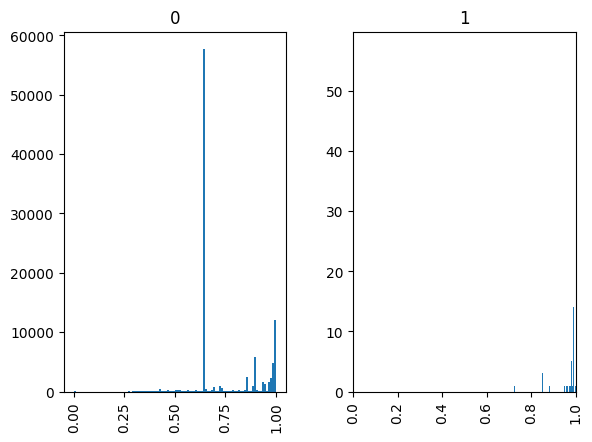

In [14]:
fitness_df.ast_ngram_terminal_n_3_score.hist(by=fitness_df['real'], bins=100)
plt.xlim(0, 1)

In [ ]:
POSITIVES_FILE = 'interactive-beta.pddl'
NEGATIVES_FILE = 'ast-real-regrowth-samples-1024.pddl'

def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = (POSITIVES_FILE, NEGATIVES_FILE),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [ ]:
print(filtered_fitness_df.shape)
filtered_fitness_df.head()

In [ ]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == NEGATIVES_FILE].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In [ ]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

print(sum(never_change))

# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Change the random seed?
* See if the GPU is faster
* Try a different from of regularization?



In [ ]:
# test_param_grid = [
#     {
#         'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
#         'fitness__weight_decay': [0.0, 0.1, 0.25],  
#         'fitness__margin': [1, 2, 4, 8],
#         # 'fitness__beta': [0.25, 1, 2, 4],
#         'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
#         'fitness__k': [16, 32, 64],  # 128
#         'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
#         # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
#         # 'fitness__dataset_energy_beta': [1, 3, 5],
#     },
# ]
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0],  
        'fitness__margin': [8, 16],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-2],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [256, 512],  # 128
        'fitness__batch_size': [2, 4],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        # 'fitness__dataset_energy_beta': [1, 3, 5],
        # 'fitness__regularization_weight': [0.01, 0.05],
    },
]

def build_regularization_function(ord: int = 1, threshold: float = 0):
    def regularization_function(model: nn.Module) -> torch.Tensor:
        w = model.fc1.weight.squeeze()  # type: ignore
        return torch.linalg.norm(w * (w.abs() >= threshold), ord)
    
    return regularization_function

regularizer = build_regularization_function(ord=1, threshold=0)

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none', n_epochs=3000, patience_epochs=10, 
    shuffle_negatives=True, device=torch.device('cuda:0'), 
    # regularizer=regularizer
    )
cv_kwargs = dict(refit='overall_ecdf', error_score='raise')  # , n_jobs=1)
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

feature_columns = [str(c) for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
for n in range(2, 7):
    feature_columns.remove(f'ast_ngram_n_{n}_score')
print([c for c in feature_columns if 'score' in c])

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid, feature_columns=feature_columns,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    energy_weighted_resampling=True, 
    # random_seed=42,
    )

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)

In [ ]:
cv.best_estimator_.named_steps['fitness'].model.fc1.weight.shape

In [ ]:
w = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.squeeze()
z = w * (w > 1e-3)
torch.linalg.norm(z, 0)

In [ ]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [ ]:
# cv.best_estimator_.fit(full_tensor)
SAVE_MODEL = True
if SAVE_MODEL:
    output_path = f'../models/cv_fitness_model_{datetime.now().strftime("%Y_%m_%d")}.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        'fitness__dataset_energy_beta': [1, 3, 5],
    },
]


cv_with_resampling, (train_tensor_with_resampling, test_tensor_with_resampling), test_results_with_resampling = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    energy_weighted_resampling=True
    )


utils.visualize_cv_outputs(cv_with_resampling, train_tensor_with_resampling, test_tensor_with_resampling, test_results_with_resampling, histogram_title_note='energy weighted resampling')

### Checking the effect of regrowth depth

In [ ]:
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]
full_binarized_tensor = utils.df_to_tensor(binarized_df, feature_columns)
full_tensor_scores = cv_no_scaling_sq_sq.best_estimator_.transform(full_binarized_tensor).detach()

In [ ]:
energy_diffs = full_tensor_scores[:, 1:] - full_tensor_scores[:, 0].unsqueeze(1)
energy_diffs.ravel().shape

In [ ]:
def extract_regrowth_depth(game_text: str):
    game_id_start = game_text.find('(game')
    game_id_section = game_text[game_id_start:game_text.find(')', game_id_start)]
    regrowth_depth = game_id_section[game_id_section.rfind('-') + 2:]
    return int(regrowth_depth)

regrowth_depts = [extract_regrowth_depth(g) for g in regrown_game_texts]

In [ ]:
plt.scatter(regrowth_depts, energy_diffs.ravel().numpy(), s=5)

In [ ]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling_sq_sq.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

In [ ]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games, square-square loss'

train_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

In [ ]:
weight_threshold = 1
weights = cv_no_scaling_sq_sq.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
weights_above_threshold = (weights.abs() > weight_threshold).numpy()
feature_columns = [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
features_with_weight_above_threshold = [feature_columns[i] for i in range(len(feature_columns)) if weights_above_threshold[i]]

with open('../data/features_with_weight_above_threshold_2022_01_24.txt', 'w') as f:
    f.write('\n'.join(features_with_weight_above_threshold))
    


In [ ]:
full_binarized_tensor = utils.df_to_tensor(binarized_df, [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS])
test_negative_scores_tensor = torch.tensor(test_negative_scores)
test_positive_scores_tensor = torch.tensor(test_positive_scores)
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]

In [ ]:
torch.topk((test_negative_scores_tensor - test_positive_scores_tensor.unsqueeze(-1)).ravel(), 30, largest=False)

In [ ]:
test_negative_scores_tensor.ravel()[836] == test_negative_scores_tensor[836 // 64, 836 % 64]

In [ ]:
utils.evaluate_energy_contributions(
    cv_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, 1036,
    feature_columns, full_binarized_tensor, real_game_texts, regrown_game_texts,
)

In [ ]:
fitness_df.columns

In [ ]:
# [c for c in fitness_df.columns if 'arg_types' in c]
fitness_df.columns.get_loc('ast_ngram_constraints_n_6_score')

In [ ]:
from argparse import Namespace
from src.fitness_features import *
# from src.fitness_ngram_models import TextNGramModel, TextMultiNGramModel, ASTMultiNGramModel, NGramASTParser

# with gzip.open('../models/fitness_featurizer_2023_02_02.pkl.gz', 'rb') as f:
#     featurizer = pickle.load(f)


In [ ]:
args = Namespace(no_binarize=False, no_merge=False)
featurizer = build_fitness_featurizer(args)

In [ ]:
np.seterr(all='raise')
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]

In [ ]:
np.seterr(all='raise')
%prun _ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]

In [ ]:
featurizer.header_registry['in_motion_arg_types'].get_all_keys()

In [ ]:
n_gram_model.model.get(('setup', 'setup_and'))

In [ ]:
n_gram_model.model.tree[('setup', 'setup_and')]

In [ ]:
d = featurizer.to_df()

In [ ]:
d.ast_ngram_setup_n_2_score

In [ ]:
keys = ['ast_ngram_' + k for k in featurizer.full_ast_registry[0]._get_all_inner_keys()]
cols = [c for c in d.columns if 'ast_ngram' in c]

key_set = set(keys)
col_set = set(cols)

for k in key_set - col_set:
    print('Only in keys:', k)

for c in col_set - key_set:
    print('Only in cols:', c)



In [ ]:
start = 10
keys[start:start + 10], cols[start:start + 10]

In [ ]:
print(cols[:20])

In [ ]:
d[[c for c in d.columns if 'ast_ngram_' in c]].head()

In [ ]:
d.ast_ngram_setup_n_5_score.hist(bins=20)

In [ ]:
(d[[c for c in d.columns if 'ast_ngram' in c]] == 1).sum()

In [ ]:
np.where(d.no_adjacent_same_modal == -1)

In [ ]:
d.game_name[np.where(d.no_adjacent_same_modal == -1)[0]]

In [ ]:
[c for c in d.columns if 'ast_ngram' in c]

In [ ]:
d.index[d.redundant_expression_found != 0]

In [ ]:
d.loc[56, :]

In [ ]:
t = regrown_game_texts[631]
a = grammar_parser.parse(t)
r = featurizer.parse(a, '', True)

In [ ]:
p = train_tensor[:, 0, :]
n = train_tensor[:, 1:, :]
print(p.shape, n.shape)
perm = torch.randperm(n.shape[0] * n.shape[1])
n_new = n.reshape(-1, n.shape[2])[perm, :].reshape(n.shape[0], n.shape[1], n.shape[2])
print(p.shape, n.shape)

In [ ]:
import numpy as np
rng = np.random.default_rng(0)

In [ ]:
fitness_df.adjacent_arg_types_agent_agent_setup.sum()

In [ ]:
[c for c in fitness_df if 'arg_types' in c]

In [ ]:
s = pd.Series([1, 0, 0.5, None, 0.25, None, 0, 1])

In [ ]:
s != 0